
# Task Object Detection - You Only Look Once Object Detection

You only look once (YOLO) is a state-of-the-art, real-time object detection system. The latest improvement of YOLO achieve mAP of 57.9% on COCO test-dev with an ability of processing images at 30 FPS.

<center>
<img src='https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/opencv-yolo/yolo_car_chase_01_output.gif' width=500>
</center>

Currently there are several version of improvements, from YOLO, YOLO9000, YOLOv2, and the latest is YOLOv3

<center>
<img src='https://miro.medium.com/max/1091/1*ju1oaoIkVUkaIPAdpehlzA.png' width=500>
</center>

<br>

In this exercise, we will build a simplified version of YOLO detection system and train it using **makeshift** detection dataset


Write down your Name and Student ID

In [1]:
## --- start your code here ----

NIM  = print('Andi Muhammad Yanwar')
Nama = print('21/480350/PA/20863')

## --- end your code here ----

Andi Muhammad Yanwar
21/480350/PA/20863


---
---
#[Part 0] Import Libraries

---
## 1 - Import Module

import the necessary modules

In [2]:
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=2,suppress=True)

download font type needed to write to the image

you can change this to another font type of your liking

In [3]:
!wget -O 'font.ttf' 'http://webpagepublicity.com/free-fonts/x/Xerox%20Sans%20Serif%20Narrow.ttf' -q

---
## 2 - Turn off Eager Execution

Since this simplified version is using old Keras backend, when using TensorFlow 2.0 we need to turn off the Eager execution

to do that run the following cell

In [4]:
tf.compat.v1.disable_eager_execution()

---
---
#[Part 1] Detection Dataset

Now the Detection Dataset is usually quite expensive to build, and the already existing datasets are usually quite large in scale. Which is too much for our simplified exercise

So let's generate a simplified dataset which is only images of string labels simulating the obects much like the image below

<center>
<img src='https://i.ibb.co/DbqcTtV/detection-data.png'>
</center>

This way we can generate a detection dataset with much cheaper process

---
## 1 - Define Class and Color

Now let's define the class and color

First, define each object label in `cl_label` list. You can change the label or even add more class if you want.

**But the last labes should always be `'background'`**

<br>

Then define what color you want the label to be drawn on the image. You can very much use black and white images, but the network will train easier if the color vary for each class

Also define the background image color outside the `cl_color` list


---
#### <font color='red'>**EXERCISE:** </font>

change or add the labels and their corresponding color


In [5]:
cl_label = ['bike',    'person',    'background']
cl_color = ['darkred', 'orangered', '']
cl_hot   = to_categorical(np.arange(len(cl_label)))

bg_color = 'LightGray'

classes  = list(zip(cl_label, cl_hot, cl_color))
nb_class = len(classes)

let's see the class list

In [6]:
print('number of class:',nb_class)

for c in classes:
    print(c)

number of class: 3
('bike', array([1., 0., 0.], dtype=float32), 'darkred')
('person', array([0., 1., 0.], dtype=float32), 'orangered')
('background', array([0., 0., 1.], dtype=float32), '')


**EXPECTED OUTPUT**:

if you're using default $3$ classes

<pre>
number of class: 3
('bike', array([1., 0., 0.], dtype=float32), 'darkred')
('person', array([0., 1., 0.], dtype=float32), 'orangered')
('background', array([0., 0., 1.], dtype=float32), '')

---
## 2 - Define Image and Grid Size
In the actual YOLO Detection system, it divides the input image into an $S\times S$ grid.
Each grid cell predicts only one object and it incorporates a fixed number of boundary boxes called **anchors** or **priors**.

<br>
<center>
<img src='https://miro.medium.com/max/667/1*4Y1PaY3ZgxKt5w84_0pNxw.jpeg' width=350>
</center>

The number anchors are defined by the shape of the bounding boxes. This tries to incorporate that in the real-life domain, the boundary boxes are not arbitrary.

<br>
<center>
<img src='https://miro.medium.com/max/504/1*8Q8r9ixjTiKLi1mrF36xCw.jpeg' width=400>
</center>

For example, cars and pedestrians have different box orientation (aspect ratio). Instead of predicting 5 arbitrary boundary boxes, we predict offsets to each of the constrained anchor boxes




---


The more cells the image is divided to increase the detection accuracy as it will be more detailed. But too much cells and the detection will slow down.

For this exercise, we will use only one anchor.

The implementation in this exercise actually support multiple anchors, but we're not going to use it.

You can, however, change the image size and grid number. For example changing it to $96\times 96$ with $3\times 3$ grid

---
#### <font color='red'>**EXERCISE:** </font>

Define the image size and grid size

In [7]:
img_size  = (64, 64)
grid_size = (2, 2)

for this exercise, we only use 1 anchor

In [8]:
nb_anchor = 1

Now calculate the cell size in each grid

In [9]:
img_w,  img_h  = img_size
grid_w, grid_h = grid_size

cell_w = img_w//grid_w
cell_h = img_h//grid_h

In [10]:
print('image w/h :', img_w, img_h)
print('grid w/h  :', grid_w, grid_h)
print('cell w/h  :', cell_w, cell_h)

image w/h : 64 64
grid w/h  : 2 2
cell w/h  : 32 32


**EXPECTED OUTPUT**:

if you're using default $64\times 64$ image with $2\times 2$ grid

<pre>
image w/h : 64 64
grid w/h  : 2 2
cell w/h  : 32 32

---
## 3 - Detection Target

This is how we will generate our dataset.

<font size=5 color='red'>**So read this carefully**</font>

<br>

* First we start off with a **blank image**

* For each grid cell, we randomly add either <font color='blue'>**ONE**</font> object or <font color='blue'>**BACKGROUND** </font>
  * Adding background means that there is no object to draw in that grid

  * If it is an object, randomly draw the object in that grid range
  * Generate the target list
* Each grid cell returns a list as the **cell target**
* All lists of cell targets of an image are then combined into the **image target** list

<br>

Now for the explanation of each list

---
### a. Cell Target

Each cell has a list of number as target consisting three parts: <br>**class score**, **bounding box**, and **object confidence**


<center>
<img src='https://i.ibb.co/BLN90ML/anchor.png' ><br><caption>grid target list</caption>
</center>

<br>

* The **class score** is one-hot label score very much like classification target, indicates what object classified in that cell location.


* The **bounding box** consists of $4$ values indicates the starting position ($x, y$ coordinates) followed by its box **width** and **height** ($w, h$)
  * The $x$ and $y$ is a scalar ranged from $0$ to number of grid $S$
  * The $w$ and $h$ is a scalar ranged from $0$ to $1$ scaling the **image width** and **image height**

* The **object confidence** score is a value range from $0$ to $1$ indicates the network confidance of the appearance of an object in that location


<br>

The length of cell target is&nbsp; $C+4+1$, where&nbsp; $C$ &nbsp;is the number of object to be detected. Usually background is not included in label, but for our exercise we did.

Thus for this exercise, with $3$ classes, the length of target should be&nbsp; $3+4+1=8$

---
### b. Multiple Anchors

As mentioned before, we can use multiple anchor box detection. This is useful if we want to detect multiple objects in one cell, or if we want to specialize different box shape for different class.

<center><img src='https://i.ibb.co/gm871y9/anchor2.jpg'><br><caption>anchor box</caption></center>

For multiple Anchors, the target list will be multiplied as many achors used

So the length will be&nbsp; $B*(C+4+1)$, where&nbsp; $C$ &nbsp;is the number of class and&nbsp; $B$ &nbsp;is the number of anchor

<center><img src='https://i.ibb.co/XkX3KS8/multi-anchors.png'><br><caption>grid target list (version A)</caption></center>

<br>

Another variation in multiple anchor box (**like the one implemented in this exercise**) is that although it uses multiple anchor, each grid only perform **single detection**.

Thus the &nbsp;$C$&nbsp; number of class only defined once at the beginning.
So the length will only be&nbsp; $C + B*(4+1)$

<br>

<center><img src='https://i.ibb.co/JxzrskB/anchor3.png'></img><br>
<caption>grid target list (version B)</caption></center>


---
### c. Image Target

Each grid cell has a list $B*(C+4+1)$. Now for an input image of $S\times S$ grid cell, we stack all those lists into a giant image target list

So the target length of an image is $S*S*\big(B*(C+4+1)\big)$

<br>

Or if we use the other alternative, like the image below, we will get list with the length of
$S*S*\big(C+B*(4+1)\big)$


<center>
<img src='https://miro.medium.com/max/2113/1*OuMJUWo2rXYA-GYU63NUGw.jpeg' width=600>
</center>

---
## 4 - Add Background Function

If in a grid, indicates by `row` and `col` position, we want to add a background target (no object), then all we have to do is generate a target in the center of that grid cell

<center>
<img src='https://i.ibb.co/D5hMN5f/grid-bg.png' width=300><br><caption>add background at $(1,0)$
</center>

For example, <br>if we have a background in grid $( 1, 0)$ from a $2\times 2$ &nbsp;grid as depicted above, then
* the target $x$ will be at $1.5$
($\text{col}+\frac{1}{2}$  )

* the target $y$ will be at $0.5$
($\text{row}+\frac{1}{2}$  )

* the width $w$ and height $h$ will be $0.5$ and $0.5$ <br>
(half the image, since it's $2\times 2$ grid)

* lastly, the object confidence is $0$

---
#### <font color='red'>**EXERCISE:** </font>

Implement the function as defined above


In [11]:
def add_background(y_hot, col, row):

    # convert y_hot vector
    # from array float into a list of integers
    y_hot = list(y_hot.astype('int'))

    # calculate bounding box
    x = col + 0.5    # col number + 1/2
    y = row +0.5    # row number + 1/2
    w = 1   # 1 / grid width
    h = 1    # 1 / grid height
    p = 0    # probability is 0

    # combine all into a single list
    target = []
    target += y_hot
    target += [x, y, w, h]
    target += [0]

    return target


Check your implementation

In [12]:
(l, y, c) = classes[-1]

print('background at (0,0):')
t = add_background(y, 0, 0)
print('tarhet :', t)
print('len(t) :', len(t), '\n')


print('background at (1,0):')
t = add_background(y, 1, 0)
print('tarhet :', t)
print('len(t) :', len(t), '\n')

background at (0,0):
tarhet : [0, 0, 1, 0.5, 0.5, 1, 1, 0]
len(t) : 8 

background at (1,0):
tarhet : [0, 0, 1, 1.5, 0.5, 1, 1, 0]
len(t) : 8 



**EXPECTED OUTPUT**:

if you're using default $3$ classes
<pre>
  background at (0,0):
  tarhet : [0, 0, 1, 0.5, 0.5, 0.5, 0.5, 0]
  len(t) : 8

  background at (1,0):
  tarhet : [0, 0, 1, 1.5, 0.5, 0.5, 0.5, 0]
  len(t) : 8


---
## 5 - Add Object Function

Then if we want to add an object sized &nbsp; $[w_\text{obj}\times h_\text{obj}]$  &nbsp;to the image at **CENTER** coordinate of $(x, y)$, <br>we need to draw the bounding box from half $w_\text{obj}$ up and half $h_\text{obj}$ left to the coordinate

<center>
<img src='https://i.ibb.co/z2X1jc6/grid-obj.png' width=300>
</center>

For example as shown in the picture, if we were to add  
* an object sized $[24\times 10]$

* to an image sized $[64\times 64]$ with $[2\times 2]$ grid frame
* at a **CENTER** coordinate of $x=20$ and $y=40$
<br>

Then the object **STARTING** coordinate to draw is
* $x_\text{obj} = 20-\frac{24}{2} = 8$

* $y_\text{obj} = 40-\frac{10}{2} = 35$
<br>

Now to get the target, we need to scale it accordingly, thus we get
* $x = 20/32 = 0.625$

* $y = 40/32 = 1.25$
* $w = 24/64 = 0.375$
* $h = 10/64 = 0.156$

Lastly, the object confidence is $1$

---
#### <font color='red'>**EXERCISE:** </font>

Implement the function as defined above


In [13]:
def add_object(img_draw, obj_idx, x, y, cell_w, cell_h, img_width, img_height):

    # retrieve the object information
    (label, y_hot, color) = classes[obj_idx]

    # convert y_hot vector
    # from array float into a list of integers
    # see implementation above
    y_hot = list(y_hot.astype('int'))

    # set object width and height
    obj_w = len(label)*6
    obj_h = 10

    # calculate object coordinates
    obj_x = x * cell_w - obj_w / 2   # x - object width / 2
    obj_y = y * cell_h - obj_h / 2   # y - object height / 2

    # draw the object (label) to image
    img_draw.text((obj_x, obj_y), label, fill=color)

    # calculate bounding box
    x = x / img_w    # x / cell width
    y = y / img_h    # y / cell height
    w = obj_w / img_w    # object width / image width
    h = obj_h / img_h    # object height / image height
    p = 1    # probability is 1

    # combine all into a single list
    target = []
    target += y_hot
    target += [x, y, w, h]
    target += [1]

    return target


Check your implementation

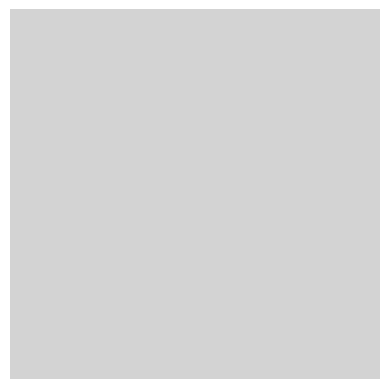

target: [1, 0, 0, 0.3125, 0.625, 0.375, 0.15625, 1]


In [14]:
test_img = Image.new('RGB', img_size, color=bg_color)
draw = ImageDraw.Draw(test_img)
x = 20
y = 40

target = add_object(draw, 0, x, y, cell_w, cell_h, img_size[0], img_size[1])

plt.imshow(test_img)
plt.axis('off')
plt.show()

print('target:',target)


**EXPECTED OUTPUT**:

if you're using default $3$ classes with $64\times 64$ image with $2\times 2$ grid

<pre>
<img src='https://i.ibb.co/hR3CMc9/add-obj.png' width=150>
target: [1, 0, 0, 0.625, 1.25, 0.375, 0.15625, 1]

---
## 6 - Generate Data Function

Now we define our generate data function which repeatedly randomize an object and put it into each grid of an image.

If the randomized object is `background`, call `add_background()` function, and
if it is an object, randomize the center location, and call `add_object()` function

---
#### <font color='red'>**EXERCISE:** </font>

Implement the function as defined above


In [15]:
def generate_data(nb_data):

    # create empty list for data and label
    x_train = []
    y_train = []

    for j in range(0, nb_data):

        # generate empty image base
        base_img = Image.new('RGB', img_size, color=bg_color)
        img_draw = ImageDraw.Draw(base_img)

        # create empty list for targets
        img_target = []

        # loop over all grid (row and col)
        for row in range(grid_w):

            for col in range(grid_h):

                # randomize object id
                # call .randint() function from numpy
                # with random range (0 , nb_class)
                idx = np.random.randint(0, nb_class)

                # get class information
                (label, y_hot, color) = classes[idx]

                # check if it's a background
                if(label=='background'):

                    # call add_background() funtion with input y_hot, col, and row
                    new_target = add_background(y_hot, col, row)

                else:
                    # randomize coordinate center location
                    # call .randint() function from numpy
                    # with random range (col*cell_w , (col+1)*cell_w)
                    x = np.random.randint(col * cell_w, (col + 1) * cell_w)

                    # call .randint() function from numpy
                    # with random range (row*cell_h , (row+1)*cell_h)
                    y = np.random.randint(row * cell_h, (row + 1) * cell_h)

                    # call add_object() function with input img_draw, idx, x, and y
                    new_target = add_object(img_draw, idx, x, y, cell_w, cell_h, img_size[0], img_size[1])

                # append new_target into img_target list
                img_target.append(new_target)

        # convert base_img into a numpy array
        np_img = np.array(base_img)

        # append np_img into x_train list
        x_train.append(np_img)

        # append img_target into y_train list
        y_train.append(img_target)

    # convert into numpy array
    x_train = np.array(x_train).astype('float32')/255
    y_train = np.array(y_train).astype('float32')

    return x_train, y_train

---
## 7 - Generate Data

And that's it

Now let's generate $5000$ training data and another $1000$ as validation data

In [16]:
x_train, y_train = generate_data(5000)
x_val, y_val     = generate_data(1000)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train shape: (5000, 64, 64, 3)
y_train shape: (5000, 4, 8)


**EXPECTED OUTPUT**:

if you're using default $3$ classes $64\times 64$ image with $2\times 2$ grid

<pre>
x_train shape: (5000, 64, 64, 3)
y_train shape: (5000, 4, 8)

Let's view the first image from training set and its target

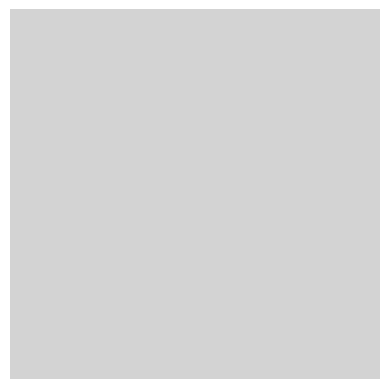

[0.  0.  1.  0.5 0.5 1.  1.  0. ]
[0.   1.   0.   0.88 0.41 0.56 0.16 1.  ]
[0.  0.  1.  0.5 1.5 1.  1.  0. ]
[0.   1.   0.   0.66 0.62 0.56 0.16 1.  ]


In [17]:
plt.imshow(x_train[0])
plt.axis('off')
plt.show()

for tgt in y_train[0]:
    print(tgt)


Now view 10 images from training set

You should see various images with random number of objects at random locations

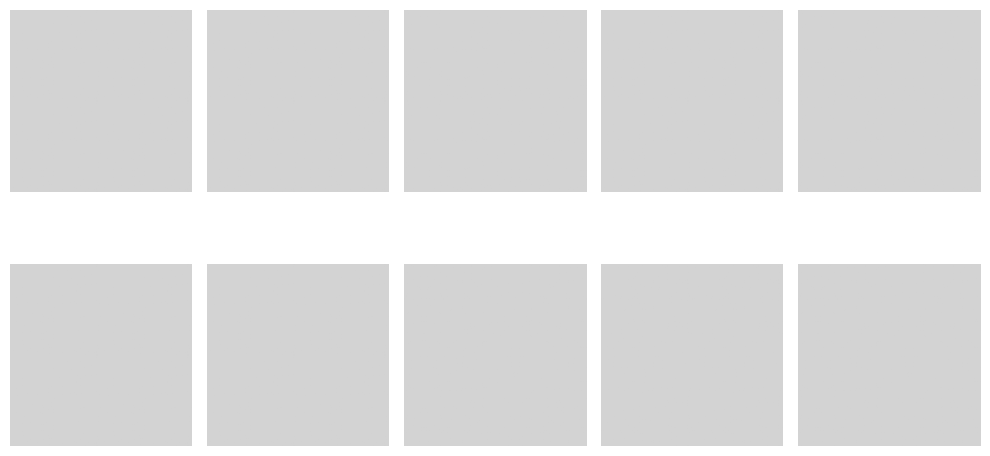

In [18]:
plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

---
---
#[Part 2] Visualizing Detection Box

Now let's create a function to draw the bounding box to an image.

**REMEMBER** that we're using target list design where each grid consist of a list with length $C + B*(4+1)$

<center><img src='https://i.ibb.co/JxzrskB/anchor3.png'></center>

---
## 1 - Box Grid Function

Given an image, the target `y_grid`, along with `col` and `row` number for current grid location, we draw the bounding box as follow:

* First, extract the class from `y_grid` and get the class index

* Then reshape the rest of `y_grid` into a matrix of `(nb_anchor, 5)`
* Then loop over each anchor box
 * Extract the $x, y, w, h, $ and $p$ from the anchor

 * The $x$ and $y$ from prediction is in range $0$ to $1$ as the result from the grid input, and not the image. <br>So to draw the prediction box, we need to add $x$ and $y$ with `row` and `col` number
 * Now to perform a simplified **Non-max Suppression**, check if confidence $p$ is higher than `max_p` from other anchor
 * If the current confidence $p$ is higher, calculate and overwrite the bounding box coordinates
 * Now, it's a little bit different when we draw the rectangle as it uses $[x1,y1,x2,y2]$ rather than using **width** and **height**
 * Set color to draw the box. <br>For example, target box is <font color=DarkGray>**gray**</font>, high confidence prediction is  <font color=LimeGreen>**green**</font>, and low confidence prediction is  <font color=RoyalBlue>**blue**</font>
 * If the class is not background, draw the box

---
#### <font color='red'>**EXERCISE:** </font>

Implement the function as defined above


In [19]:
def draw_box_grid(draw, y_grid, row=0, col=0, pad=0, is_prediction=False, threshold  = 0.1):

    # initialize max probability = 0
    max_p   = 0

    # get class from y_grid[0:nb_class]
    y_class = y_grid[:nb_class]

    # get class id, use np.argmax() with input y_class
    y_pred  = np.argmax(y_class)

    # reshape the rest of anchor list into (nb_anchor, 5)
    anchor_box = y_grid[nb_class:].reshape(nb_anchor, 5)

    # loop over anchor box
    for b in anchor_box:

        # retrieve x, y, w, h and p
        # from b[0] to b[4]
        x = b[0]
        y = b[1]
        w = b[2]
        h = b[3]
        p = b[4]

        # add row number to x
        x += row
        # add col number to y
        y += col

        # if current probability is higher than max
        if p > max_p:
            max_p = p
            rx1   = int(x * cell_w - w * img_size[0] / 2 + pad)  # x*cell width - w*image width/2 + pad
            ry1   = int(y * cell_h - h * img_size[1] / 2 + pad)  # y*cell height - h*image height/2 + pad
            rx2   = int(w * img_size[0] + rx1)  # w*image width + rx1
            ry2   = int(h * img_size[1] + ry1)  # h*image height + ry1

    # is object if probability is higher than threshold
    is_object = p > threshold

    # set color box
    if is_prediction:
        if is_object:
            box_color = 'LimeGreen'
        else:
            box_color = 'RoyalBlue'
    else:
        box_color = 'DarkGray'

    # if class is not background, draw the box
    if y_pred!=nb_class-1:
        draw.rectangle([rx1, ry1, rx2, ry2], outline=box_color)

    return y_pred, is_object

Check your implementation

original target [1, 0, 0, 0.3125, 0.625, 0.375, 0.15625, 1]


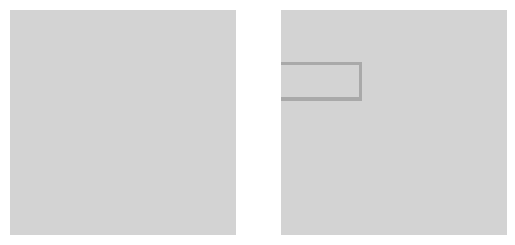

predicted: 0 , is object? True


In [20]:
test_img = Image.new('RGB', img_size, color=bg_color)
draw = ImageDraw.Draw(test_img)
x = 20
y = 40

target = add_object(draw, 0, x, y, cell_w, cell_h, img_size[0], img_size[1])
plt.subplot(121)
plt.imshow(test_img)
plt.axis('off')

print('original target',target)
target = np.array(target)

y_pred, is_object = draw_box_grid(draw, target, row=0, col=0, is_prediction=False)
plt.subplot(122)
plt.imshow(test_img)
plt.axis('off')
plt.show()
print('predicted:',y_pred, ', is object?',is_object)

**EXPECTED OUTPUT**:

if you're using default $3$ classes $64\times 64$ image with $2\times 2$ grid

<pre>original target [1, 0, 0, 0.625, 1.25, 0.375, 0.15625, 1]
<img src='https://i.ibb.co/ByVjcF3/box-test.png' width=300>
predicted: 0 , is object? True</pre>

---
## 2 - Draw Bounding Box Function

Now we define function to iterate over grid and draw the bounding box in it.
Here's step by step of this function
* First we pad the image with zero pixels as a place to write the prediction class

* Loop over the grid
 * Draw the target box

 * If prediction is provided, draw the prediction box
 * write the predicted class on top and bottom of the image<br> note that the code only designed for $2\times 2$ grid
 * set the text color. <br>For example <font color='darkgreen'>**green**</font> if it's the correct class, <font color='deeppink'>**pink**</font> if it's wrong or having low confidence, <br>and **black** if prediction is not provided

---
#### <font color='red'>**EXERCISE:** </font>

Implement the function as defined above


In [21]:
def draw_bbox(np_img, target, prediction=None, pad=10, threshold=0.1):

    # rescale np_img by multiplying it with 255
    img = np_img * 255

    # add white padding as a place to write class prediction
    img = np.pad(img, ((pad,pad),(pad,pad), (0,0)), 'constant', constant_values=255)

    # generate image
    img      = Image.fromarray(img.astype('uint8'), 'RGB')
    img_draw = ImageDraw.Draw(img)
    font     = ImageFont.truetype(r'font.ttf', 10)

    for row in range(grid_w):

        for col in range(grid_h):

            # get current target for this grid
            target_grid = target[col*grid_h+row]

            # call draw_box_grid() function with input img_draw, target_grid, and pad=pad
            y_act,_ = draw_box_grid(img_draw, target_grid, row, col, pad=pad)

            if prediction is not None:

                # get current prediction for this grid
                prediction_grid = prediction[col*grid_h+row]

                # call draw_box_grid() function with input
                # img_draw, prediction_grid, row, col,
                # pad=pad, is_prediction=True, and threshold=threshold
                y_pred, conf = draw_box_grid(img_draw, prediction_grid, row, col, pad=pad, is_prediction=True, threshold=threshold)

                # set color for predicted class writing
                if y_pred == y_act and conf:
                    # correct detection
                    fill = 'DarkGreen'
                    s = str(y_act)+'-'+str(y_pred)
                else:
                    # wrong detection or low confidence
                    fill = 'DeepPink'
                    s = str(y_act)+'-'+str(y_pred)+' (?)'

            else:
                # drawing target
                s = str(y_act)
                fill = 'black'

            # draw text class target/prediction
            img_draw.text((row+row*cell_w+pad, col+img_h*col+1+col*8), s, fill=fill, font=font)

    # convert img into a numpy array
    img = np.array(img)

    return img


Check your implementation

You should see that the "objects" are correctly localized with its bounding boxes.

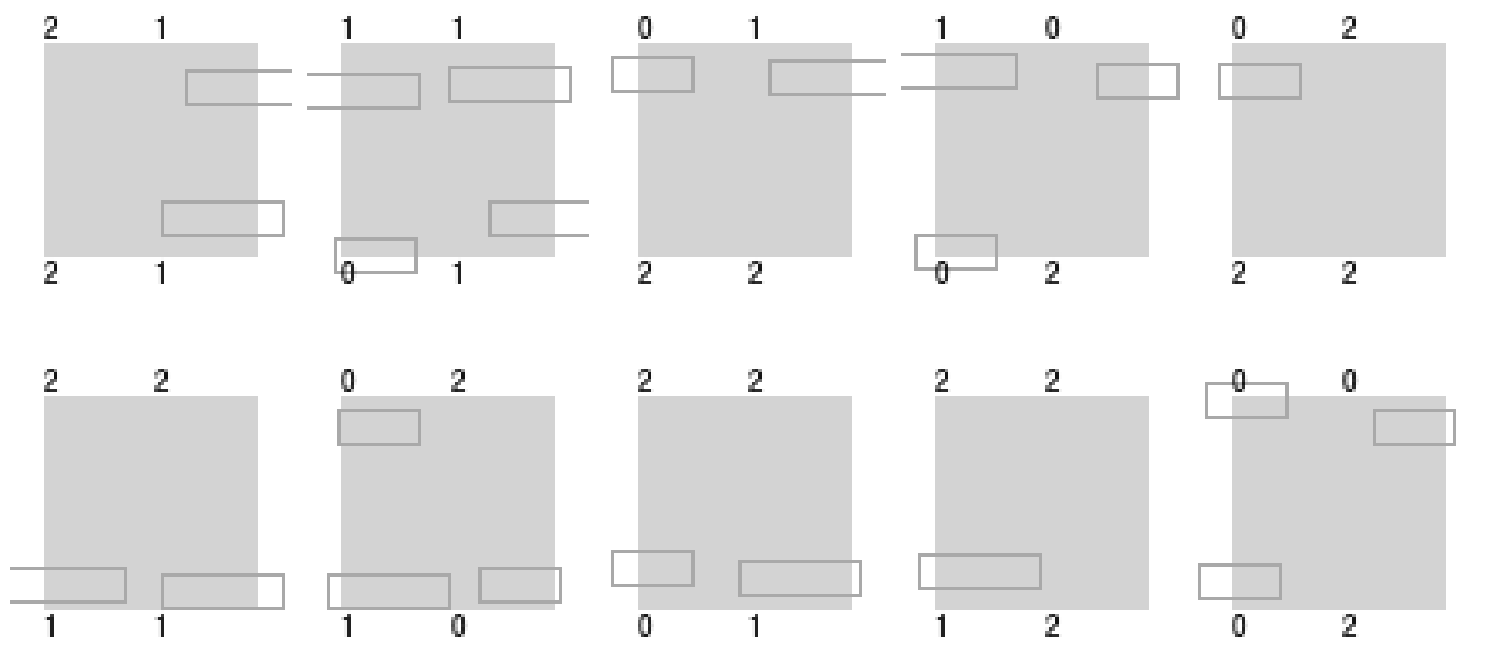

In [22]:
plt.figure(figsize=(15,8))
for i in range(10):
    img = draw_bbox(x_train[i], y_train[i])
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

---
---
#[Part 3] YOLO Detection

And we're arrive at the main function, the YOLO Detection itself

<center>
<img src='https://miro.medium.com/max/804/1*jtnrhMFNwGxiQmkY6LkdCQ.jpeg'>
</center>


First we define our classification model. The original YOLO network consists of $24$ convolutional layers alternating between $3\times 3$ convolution and $1\times 1$ bottleneck layers to reduce the features space from preceding layers, followed by $2$ FC layers from a $448\times 448$ image input. But for our simple exercise, we won't need that big network.

So let's define our own

---
## 1 - Define Input Shape

Use Functional API to build the model.


---
#### <font color='red'>**EXERCISE:** </font>
Define input and output shape

In [23]:
# input shape is a tuple of image height, image width, and 3 channel
input_shape   = (img_h, img_w, 3)

# total grid is grid width * grid height
total_grid    = grid_w * grid_h

# anchor length is number class + number anchor * 5
anchor_length = nb_class + nb_anchor * 5

Check your implementation

In [24]:
print('input shape   :', input_shape)
print('total grid    :', total_grid)
print('anchor length :', anchor_length)

input shape   : (64, 64, 3)
total grid    : 4
anchor length : 8


**EXPECTED OUTPUT**:

if you're using default $3$ classes $64\times 64$ image with $2\times 2$ grid

<pre>
input shape   : (64, 64, 3)
total grid    : 4
anchor length : 8

---
## 2 - Define Classification Model

Use Functional API to build the model.


---
#### <font color='red'>**EXERCISE:** </font>
Build model implementing the architecture as follow

<pre>
    * <b>Input</b> layer of  <font color='blue'><b>(img_h,img_w,3)</b></font>  
    * <b>conv</b> layer with <font color='blue'><b>16</b></font> filters of <font color='blue'><b>1x1</b></font> without activation
    * <b>conv</b> layer with <font color='blue'><b>32</b></font> filters of <font color='blue'><b>3x3</b></font> without activation
    * <b>LeakyReLU</b> activation with alpha <font color='blue'><b>0.01</b></font>
    * <b>MaxPool2D</b> layer      
    * <b>conv</b> layer with <font color='blue'><b>16</b></font> filters of <font color='blue'><b>3x3</b></font> without activation
    * <b>conv</b> layer with <font color='blue'><b>32</b></font> filters of <font color='blue'><b>3x3</b></font> without activation
    * <b>LeakyReLU</b> activation with alpha <font color='blue'><b>0.01</b></font>
    * <b>MaxPool2D</b> layer      
    * <b>Flatten</b> layer
    * <b>Fully connected</b> layer with <font color='blue'><b>256</b></font> neurons and activation <font color='blue'><b>sigmoid</b></font>
    * <b>Fully connected</b> layer with <font color='blue'><b>output_shape</b></font> neurons and activation <font color='blue'><b>sigmoid</b></font>
    * <b>Reshape</b> layer to reshape output activation to <font color='blue'><b>(grid, anchors)</b></font>  shape
</pre>

In [25]:
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model

# define Input() layer with shape=input_shape
input_tensor = Input(shape=input_shape)

# add conv2d to input_tensor with 16 filters, kernel size 1
x = Conv2D(16, kernel_size=1)(input_tensor)

# add conv2d to x with 32 filters, kernel size 3
x = Conv2D(32, kernel_size=3)(x)

# add leakyrelu to x alpha=0.3
x = LeakyReLU(alpha=0.3)(x)

# add maxpool2d layer to x
x = MaxPooling2D()(x)

# add conv2d to x with 16 filters, kernel size 3
x = Conv2D(16, kernel_size=3)(x)

# add conv2d to x with 32 filters, kernel size 3
x = Conv2D(32, kernel_size=3)(x)

# add leakyrelu to x alpha=0.3
x = LeakyReLU(alpha=0.3)(x)

# add maxpool2d layer to x
x = MaxPooling2D()(x)

# add flatten layer to x
x = Flatten()(x)

# add dense layer to x with 256 neurons and sigmoid activation
x = Dense(256, activation='sigmoid')(x)

# add dense layer to x with total_grid * anchor_length neurons and sigmoid activation
x = Dense(total_grid * anchor_length, activation='sigmoid')(x)

# add reshape layer to x with input (total_grid, anchor_length)
output_tensor = Reshape((total_grid, anchor_length))(x)

# initialize model by calling Model() function with input input_tensor and output_tensor
model = Model(input_tensor, output_tensor)


Now to check your implementation

In [26]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        64        
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        4640      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 16)        4624      
                                                             

**EXPECTED OUTPUT**:

if you're using default $3$ classes $64\times 64$ image with $2\times 2$ grid

<pre>
input_? (InputLayer)         [(None, 64, 64, 3)]       0         
conv2d (Conv2D)              (None, 64, 64, 16)        64        
...
dense_? (Dense)              (None, 32)                8224      
reshape (Reshape)            (None, 4, 8)              0         

Total params: 1,406,896
Trainable params: 1,406,896
Non-trainable params: 0
_________________________________________________________________

Visualize the Network architecture

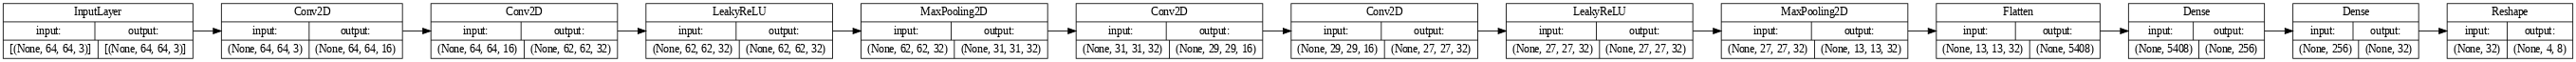

In [27]:
plot_model(model, show_shapes=True,
    show_layer_names=False,
    rankdir='LR',
    expand_nested=False,
    dpi=60
)

---
## 3 - Define Loss

YOLO uses sum-squared error between the predictions and the ground truth to calculate loss.

The loss function composes of:
* the **classification loss.**
* the **localization loss** (errors between the predicted boundary box and the ground truth).
* the **confidence loss** (the objectness of the box).

---
### a. Classification Loss
If an object is detected, the classification loss at each cell is the squared error of the class conditional probabilities for each class:

$$
 \sum_{i=0}^{S^2}{1}_i^\text{obj} \sum_{c \in \text{classes}}\big(p_i(c)-\hat{p_i}(c)\big)^2
$$

---
### b. Localization Loss
The localization loss measures the errors in the predicted boundary box locations and sizes. We only count the box responsible for detecting the object.

$$
 x\lambda_\text{coord}\sum_{i=0}^{S^2}\sum_{j=0}^{B}{1}_{ij}^\text{obj} \big[(x_i-\hat{x}_i)^2+(y_i-\hat{y}_i)^2\big]\\+\lambda_\text{coord}\sum_{i=0}^{S^2}\sum_{j=0}^{B}\rm{1}_{ij}^\text{obj} \big[(\sqrt{w_i}-\sqrt{\hat{w}_i})^2+(\sqrt{h_i}-\sqrt{\hat{h}_i})^2\big]
$$

---
### c. Confidence Loss
If an object is detected in the box, the confidence loss (measuring the objectness of the box) is:
$$
\sum_{i=0}^{S^2}\sum_{j=0}^{B}{1}_{ij}^\text{obj}(C_i-\hat{C}_i)^2
$$

If an object is **NOT** detected in the box, the confidence loss is:
$$
\lambda_\text{noobj}\sum_{i=0}^{S^2}\sum_{j=0}^{B}{1}_{ij}^\text{noobj}(C_i-\hat{C}_i)^2
$$

---
### d. Complete Implementation

Now don't be disheartened, we already prepared the loss implementation for you. So read the code carefully.

In [28]:
def custom_loss(y_true, y_pred):

    grid = np.array([ [[float(x),float(y)]]*nb_anchor   for y in range(grid_h) for x in range(grid_w)])

    # get the actual and predicted class
    y_true_class   = y_true[...,0:nb_class-1]
    y_pred_class   = y_pred[...,0:nb_class-1]

    # get the actual and predicted box
    pred_boxes     = K.reshape(y_pred[...,nb_class:], (-1,grid_w*grid_h,nb_anchor,5))
    true_boxes     = K.reshape(y_true[...,nb_class:], (-1,grid_w*grid_h,nb_anchor,5))

    # get predicted coordinates and confidence
    y_pred_xy      = pred_boxes[...,0:2] + K.variable(grid)
    y_pred_wh      = pred_boxes[...,2:4]
    y_pred_conf    = pred_boxes[...,4]

    # get actual coordinates and confidence
    y_true_xy      = true_boxes[...,0:2]
    y_true_wh      = true_boxes[...,2:4]
    y_true_conf    = true_boxes[...,4]

    # calculate classification loss
    clss_loss      = K.sum(K.square(y_true_class - y_pred_class), axis=-1)

    # calculate localization loss
    xy_loss        = K.sum(K.sum(K.square(y_true_xy - y_pred_xy),axis=-1)*y_true_conf, axis=-1)
    wh_loss        = K.sum(K.sum(K.square(K.sqrt(y_true_wh) - K.sqrt(y_pred_wh)), axis=-1)*y_true_conf, axis=-1)

    # non-max suppression
    intersect_wh   = K.maximum(K.zeros_like(y_pred_wh), (y_pred_wh + y_true_wh)/2 - K.abs(y_pred_xy - y_true_xy) )
    intersect_area = intersect_wh[...,0] * intersect_wh[...,1]

    true_area      = y_true_wh[...,0] * y_true_wh[...,1]
    pred_area      = y_pred_wh[...,0] * y_pred_wh[...,1]

    # calculate intersection over union
    union_area     = pred_area + true_area - intersect_area
    iou            = intersect_area / union_area

    # calculate confidence loss
    conf_loss      = K.sum(K.square(y_true_conf*iou - y_pred_conf)*y_true_conf, axis=-1)

    # sum all losses
    d = clss_loss + xy_loss + wh_loss + conf_loss

    return d

---
## 4 - Compile Model

Now compile model by adding the custom loss and Adam optimizer

---
#### <font color='red'>**EXERCISE:** </font>
compile model using custom_loss and Adam optimizer with lr=0.001

In [29]:
from tensorflow.keras.optimizers import Adam

# initialize Adam optimizer with lr=0.001
myAdam = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

# compile model with loss=custom_loss and optimizer=myAdam
model.compile(loss=custom_loss, optimizer=myAdam)

---
## 5 - Train Model

Train the model for 80 epochs

In [30]:
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=512, epochs=80)

Train on 5000 samples, validate on 1000 samples
Epoch 1/80
5000/5000 [==============================] - ETA: 0s - loss: 0.6980

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


5000/5000 [==============================] - 19s 4ms/sample - loss: 0.6980 - val_loss: 0.5553
Epoch 2/80
5000/5000 [==============================] - 1s 196us/sample - loss: 0.5456 - val_loss: 0.5465
Epoch 3/80
5000/5000 [==============================] - 1s 155us/sample - loss: 0.5409 - val_loss: 0.5444
Epoch 4/80
5000/5000 [==============================] - 1s 150us/sample - loss: 0.5389 - val_loss: 0.5426
Epoch 5/80
5000/5000 [==============================] - 1s 160us/sample - loss: 0.5381 - val_loss: 0.5420
Epoch 6/80
5000/5000 [==============================] - 1s 147us/sample - loss: 0.5376 - val_loss: 0.5416
Epoch 7/80
5000/5000 [==============================] - 1s 157us/sample - loss: 0.5370 - val_loss: 0.5413
Epoch 8/80
5000/5000 [==============================] - 1s 159us/sample - loss: 0.5370 - val_loss: 0.5411
Epoch 9/80
5000/5000 [==============================] - 1s 165us/sample - loss: 0.5369 - val_loss: 0.5412
Epoch 10/80
5000/5000 [==============================] - 1

**EXPECTED OUTPUT**:
<pre>
your loss should start around 0.6 and end around 0.01 after 80 epochs

Visualize training history

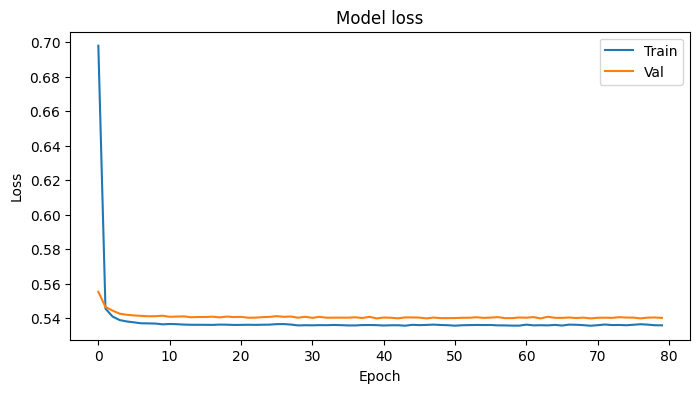

In [31]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.subplots_adjust(wspace=0.2)

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()


---
## 6 - Test Detection

Let's show the detection results

---
### a. Using Data Train

First, let's see the performance on training data

In [32]:
y_pred = model.predict(x_train)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


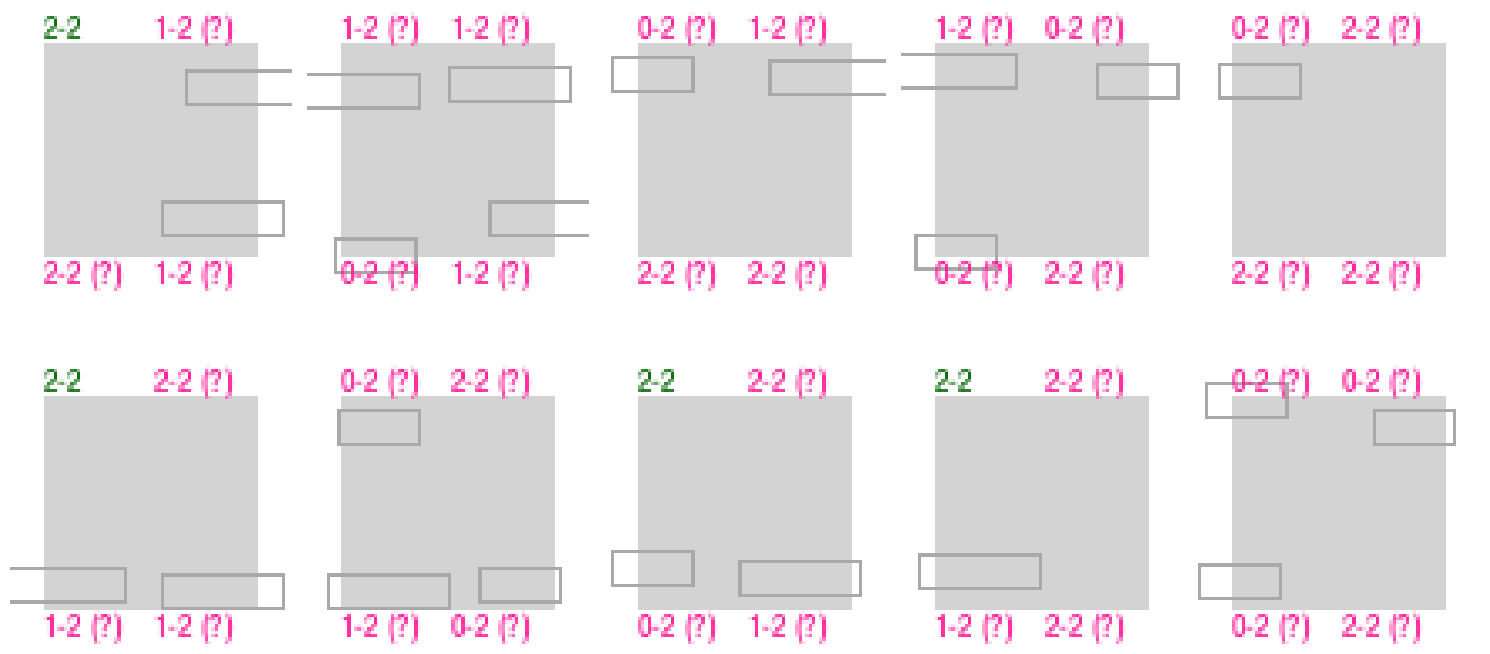

In [33]:
plt.figure(figsize=(15,8))
for i in range(10):
    img = draw_bbox(x_train[i], y_train[i], y_pred[i], threshold=0.1)
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

You should see that most of the objects are detected with quite precision

the <font color=DeepPink>**pink**</font> label and <font color=RoyalBlue>**blue**</font> detection box means low confidence or wrong classification

you can train it longer to get more precision on the detection box

you can also lower the threshold when drawing the detection box


---
### b. Using Data Validation


Now view the detection results on validation data

In [34]:
y_pred_val = model.predict(x_val)

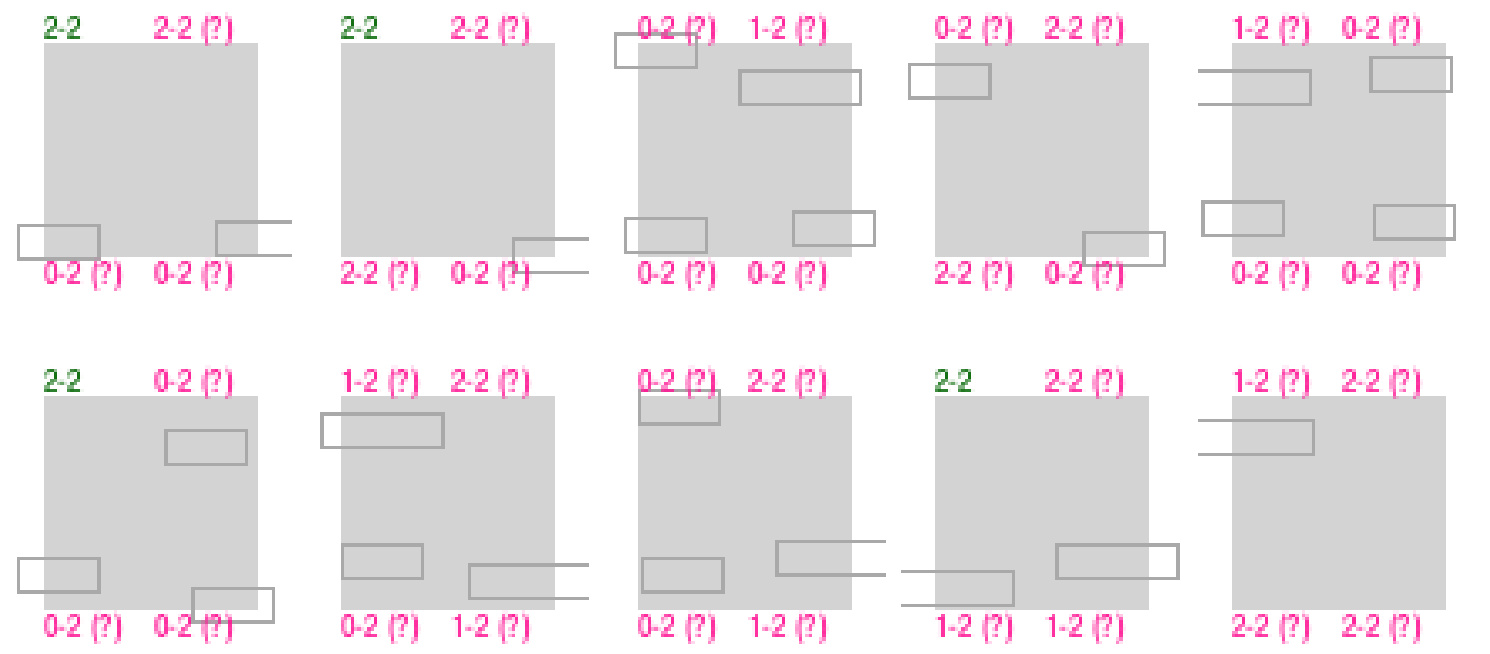

In [35]:
plt.figure(figsize=(15,8))
for i in range(10):
    img = draw_bbox(x_val[i], y_val[i], y_pred_val[i], threshold=0.1)
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

---
### c. Using Data Test

Lastly, let's generate another 20 new data, and test it

In [36]:
# generate 20 new data
x_test, y_test = generate_data(20)

# predict new data
y_pred_test = model.predict(x_test)

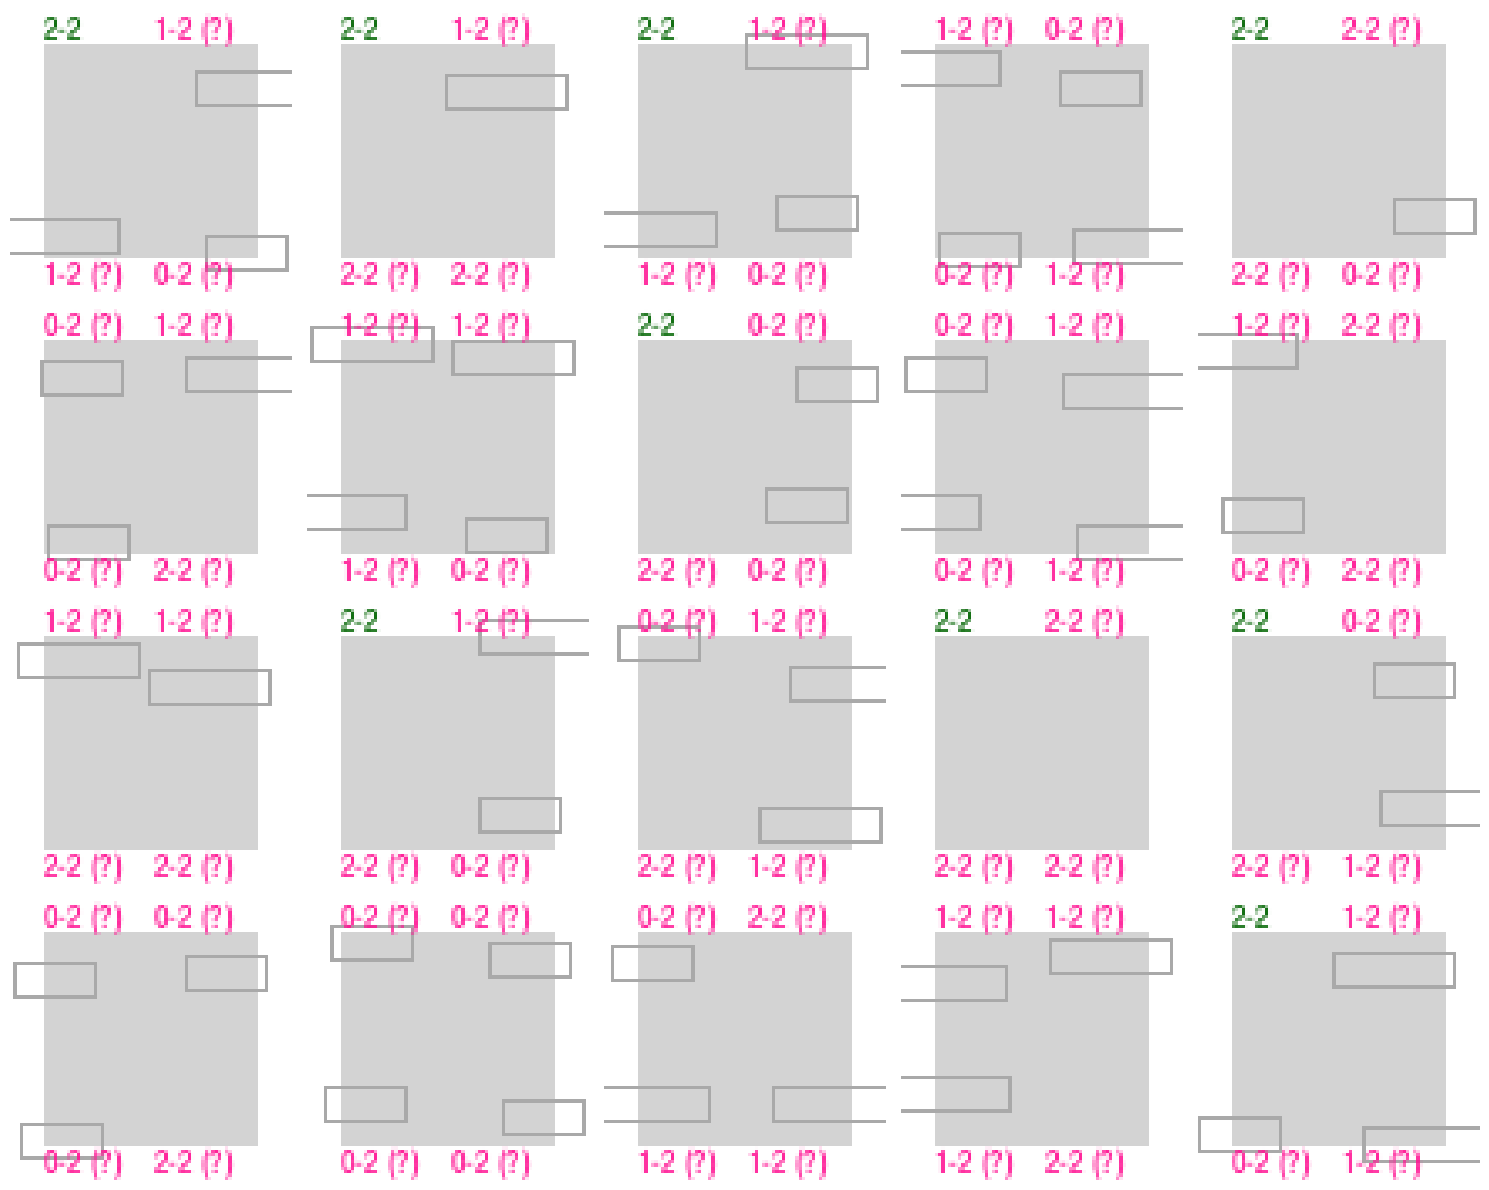

In [37]:
plt.figure(figsize=(15,12))
for i in range(20):
    img = draw_bbox(x_test[i], y_test[i], y_pred_test[i], threshold=0.1)
    plt.subplot(4,5,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()


---

# Congratulation, You've Completed Exercise abaout Object Detection

